In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, f1_score, recall_score, precision_score
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline

In [2]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


# Data Visualization

In [24]:
def plot_stacked_bars(dataframes, titles, size_=(20, 15), rot_=0, legend_="upper right"):
    num_plots = len(dataframes)
    num_rows = (num_plots + 1) // 2
    
    fig, axes = plt.subplots(num_rows, 2, figsize=size_)
    axes = axes.flatten()
    
    for i in range(num_plots):
        ax = axes[i]
        df = dataframes[i]
        
        ax = df.plot(kind='bar', stacked=True, ax=ax, rot=rot_, title=titles[i], color=['mediumspringgreen','coral'])
        annotate_stacked_bars(ax, textsize=16)
        ax.legend(["Retention", "Churn"], loc=legend_)
        ax.set_ylabel("Company base (%)")

    for j in range(num_plots, len(axes)):
        axes[j].axis('off') 
        
    plt.tight_layout()
    plt.show()

def annotate_stacked_bars(ax, pad=0.99, colour="black", textsize=20):
    for p in ax.patches:
        value = str(round(p.get_height(), 1))
        if value == '0.0':
            continue
        ax.annotate(
            value,
            ((p.get_x() + p.get_width() / 2) * pad - 0.05, (p.get_y() + p.get_height() / 2) * pad),
            color=colour, size=textsize)

## Target Variable: Churn

In [11]:
churn = df[['customerID', 'Churn']]
churn.columns = ['Companies', 'Churn']
churn_total = churn.groupby(churn['Churn']).count()
churn_percentage = churn_total / churn_total.sum() * 100

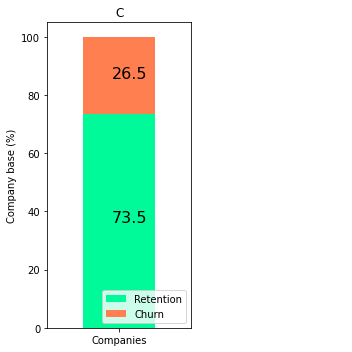

In [25]:
plot_stacked_bars([churn_percentage.transpose()], "Churning status", (5, 5), legend_="lower right")

The distribution of the target is imbalanced due to the fact that retention comprises nearly 3/4 of the overall distributions.

## Demographic Information: gender, SeniorCitizen, Partner, Dependents

### gender 

In [15]:
gender = df[['customerID', 'gender', 'Churn']]
gender = gender.groupby([gender['gender'], gender['Churn']])['customerID'].count().unstack(level=1)
gender

Churn,No,Yes
gender,,
Female,2549,939
Male,2625,930


In [16]:
gender_churn = (gender.div(gender.sum(axis=1), axis=0) * 100).sort_values(by=['Yes'], ascending=False)

gender_churn

Churn,No,Yes
gender,,
Female,73.079128,26.920872
Male,73.839662,26.160338


### SeniorCitizen 

In [17]:
senior_citizen = df[['customerID', 'SeniorCitizen', 'Churn']]
citizen = senior_citizen.groupby([senior_citizen['SeniorCitizen'], senior_citizen['Churn']])['customerID'].count().unstack(level=1)
senior_citizen_churn = (citizen.div(citizen.sum(axis=1), axis=0) * 100).sort_values(by=['Yes'], ascending=False)

senior_citizen_churn

Churn,No,Yes
SeniorCitizen,,
1,58.318739,41.681261
0,76.393832,23.606168


In [18]:
citizen

Churn,No,Yes
SeniorCitizen,,
0,4508,1393
1,666,476


### Partner 

In [19]:
partner = df[['customerID', 'Partner', 'Churn']]
partner = partner.groupby([partner['Partner'], partner['Churn']])['customerID'].count().unstack(level=1)
partner_churn = (partner.div(partner.sum(axis=1), axis=0) * 100).sort_values(by=['Yes'], ascending=False)

partner_churn

Churn,No,Yes
Partner,,
No,67.042021,32.957979
Yes,80.335097,19.664903


### Dependents 

In [20]:
dependents = df[['customerID', 'Dependents', 'Churn']]
dependents = dependents.groupby([dependents['Dependents'], dependents['Churn']])['customerID'].count().unstack(level=1)
dependents_churn = (dependents.div(dependents.sum(axis=1), axis=0) * 100).sort_values(by=['Yes'], ascending=False)

dependents_churn

Churn,No,Yes
Dependents,,
No,68.720860,31.279140
Yes,84.549763,15.450237


### Plot 

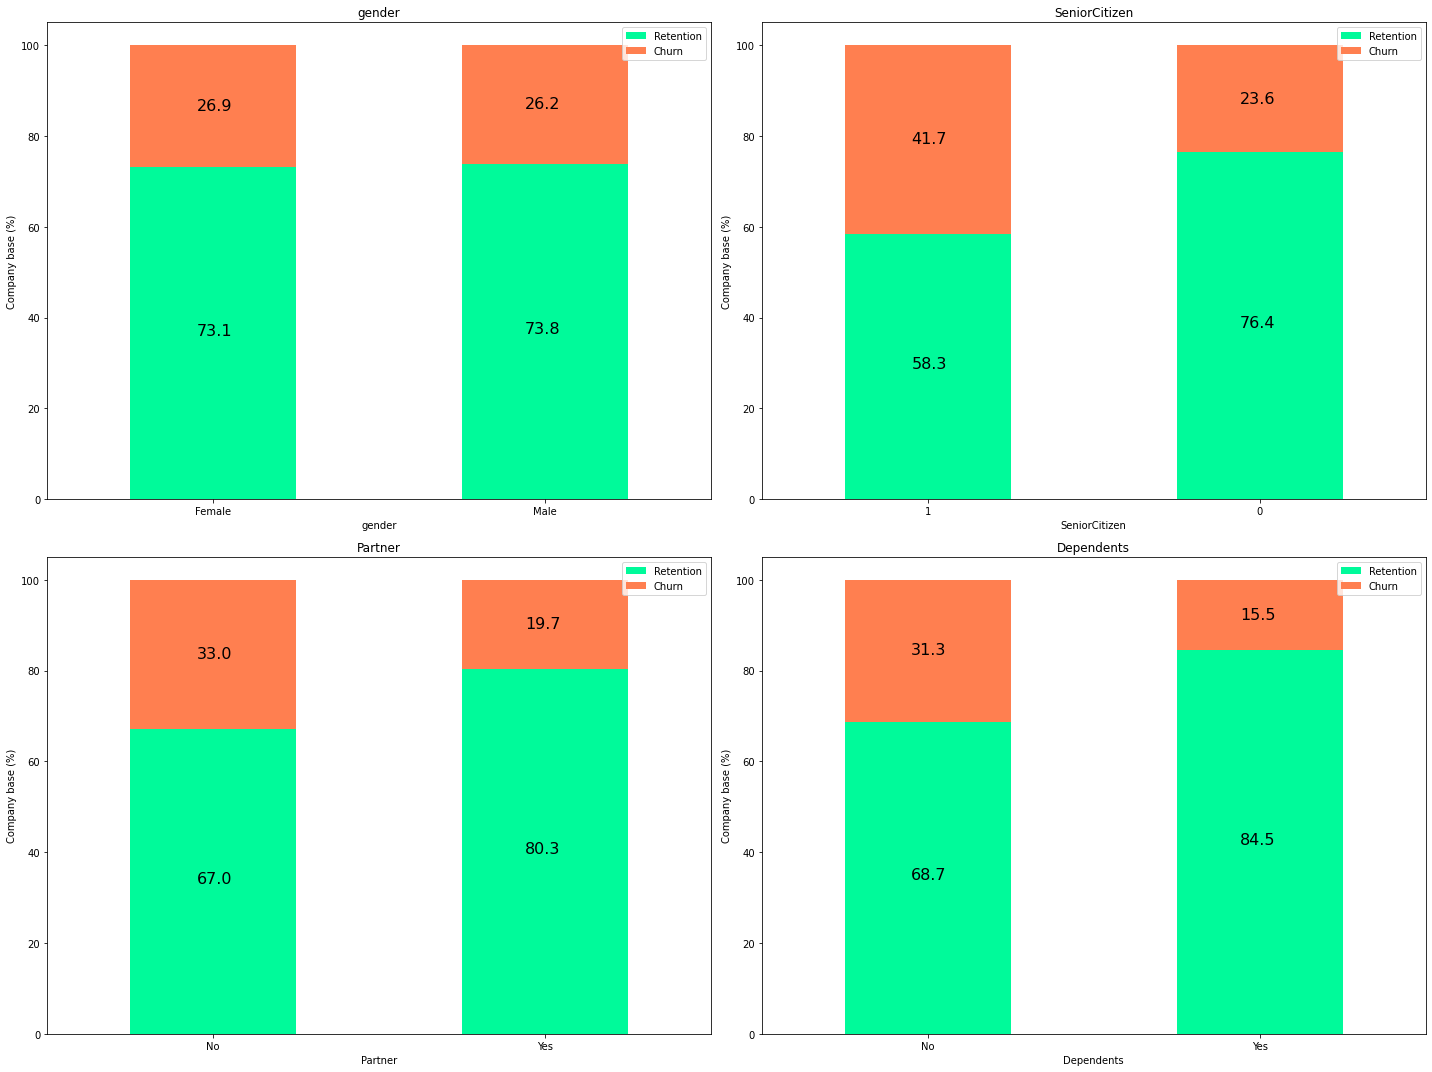

In [26]:
df_demographic = [gender_churn, senior_citizen_churn, partner_churn, dependents_churn]
titles = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']
plot_stacked_bars(df_demographic, titles)

- The churn rate is roughly equal between males and females.
- The number of senior citizen is low.
- Nearly 40% of customer churn are senior citizens.
- Customer who has a partner churned less than a customer who do not have a partner.
- Customers who have dependents demonstrate lower churn rates compared to customers who do not have dependents.

## Customer Account Inforrmation 

### Contract 

In [27]:
contract = df[['customerID', 'Contract', 'Churn']]
contract = contract.groupby([contract['Contract'], contract['Churn']])['customerID'].count().unstack(level=1)
contract_churn = (contract.div(contract.sum(axis=1), axis=0) * 100).sort_values(by=['Yes'], ascending=False)

contract_churn

Churn,No,Yes
Contract,,
Month-to-month,57.290323,42.709677
One year,88.730482,11.269518
Two year,97.168142,2.831858


### PaperlessBilling

In [28]:
billing = df[['customerID', 'PaperlessBilling', 'Churn']]
billing = billing.groupby([billing['PaperlessBilling'], billing['Churn']])['customerID'].count().unstack(level=1)
billing_churn = (billing.div(billing.sum(axis=1), axis=0) * 100).sort_values(by=['Yes'], ascending=False)

billing_churn

Churn,No,Yes
PaperlessBilling,,
Yes,66.434908,33.565092
No,83.669916,16.330084


### PaymentMethod

In [29]:
payment = df[['customerID', 'PaymentMethod', 'Churn']]
payment = payment.groupby([payment['PaymentMethod'], payment['Churn']])['customerID'].count().unstack(level=1)
payment_churn = (payment.div(payment.sum(axis=1), axis=0) * 100).sort_values(by=['Yes'], ascending=False)

payment_churn

Churn,No,Yes
PaymentMethod,,
Electronic check,54.714588,45.285412
Mailed check,80.893300,19.106700
Bank transfer (automatic),83.290155,16.709845
Credit card (automatic),84.756899,15.243101


### Plot

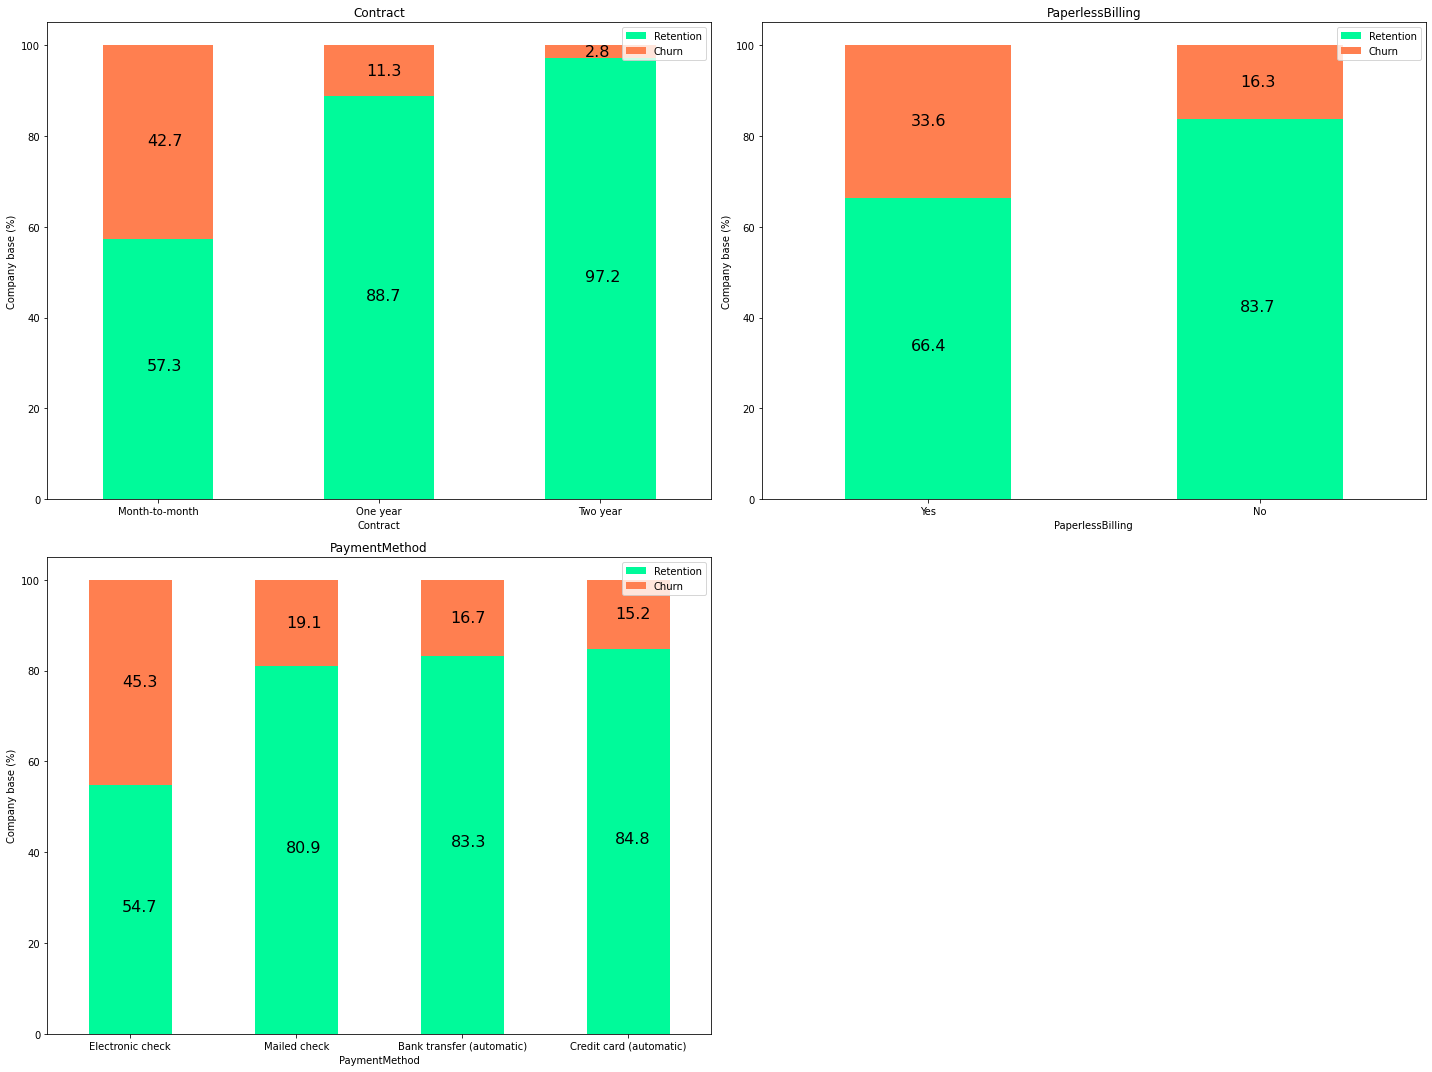

In [30]:
df_acc_info = [contract_churn, billing_churn, payment_churn]
titles = ['Contract', 'PaperlessBilling', 'PaymentMethod']
plot_stacked_bars(df_acc_info, titles)

- Customer churning for month-to-month contracts is quite high. Probably it happens because customers are testing Telco for one month and then they decide whether they want to renew the contract or not.
- Customers subscribed to paperless billing demonstrates a higher customer churn rates than who don't.
- Customers who use electronic check payment methods have the most and a high number of churn customers.

### tenure, MonthlyCharges, and TotalCharges

In [32]:
def plot_distribution(dataframe, column, ax, bins_=50):
    temp = pd.DataFrame({"Retention": dataframe[dataframe["Churn"]=='No'][column],
                         "Churn":dataframe[dataframe["Churn"]=='Yes'][column]})
    temp[["Retention","Churn"]].plot(kind='hist', bins=bins_, ax=ax, stacked=True, 
                                     alpha=0.5, color=['mediumspringgreen','salmon'])
    ax.set_xlabel(column)
    ax.ticklabel_format(style='plain', axis='x')

In [33]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [35]:
cust_info_num = df[['customerID', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']]

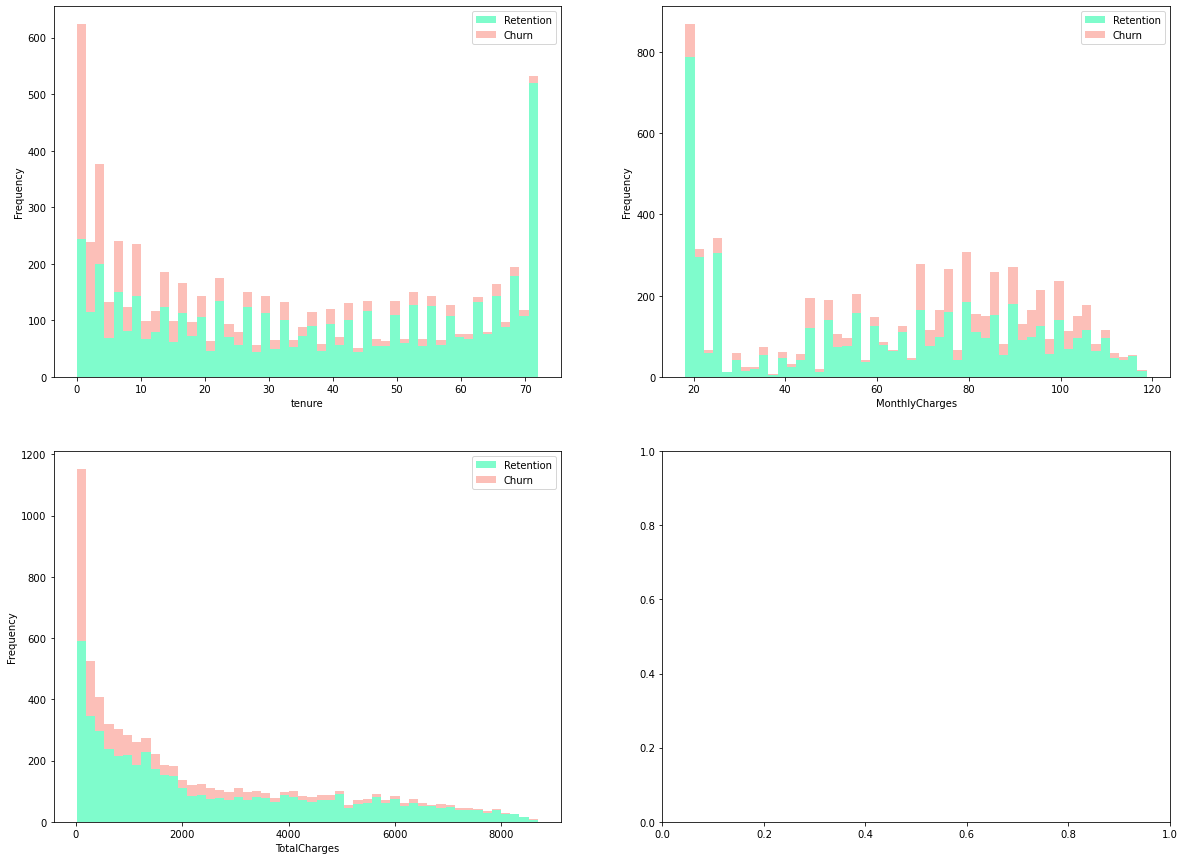

In [36]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))

plot_distribution(cust_info_num, 'tenure', ax[0,0])
plot_distribution(cust_info_num, 'MonthlyCharges', ax[0,1])
plot_distribution(cust_info_num, 'TotalCharges', ax[1,0])

- Total charges displays a positively skewed distribution. 
- Customers who has a lower total charges churned more than customers who has a higher total charges.
- Higher monthly charges result in higher churn rates.
- Lower tenure (new customers) has a higher churn rates.

## Service Information 

### PhoneService

In [37]:
phone_service = df[['customerID', 'PhoneService', 'Churn']]
phone_service = phone_service.groupby([phone_service['PhoneService'], phone_service['Churn']])['customerID'].count().unstack(level=1)
phone_service_churn = (phone_service.div(phone_service.sum(axis=1), axis=0) * 100).sort_values(by=['Yes'], ascending=False)

phone_service_churn

Churn,No,Yes
PhoneService,,
Yes,73.290363,26.709637
No,75.073314,24.926686


In [38]:
phone_service

Churn,No,Yes
PhoneService,,
No,512,170
Yes,4662,1699


### MultipleLines

In [39]:
lines = df[['customerID', 'MultipleLines', 'Churn']]
lines = lines.groupby([lines['MultipleLines'], lines['Churn']])['customerID'].count().unstack(level=1)
lines_churn = (lines.div(lines.sum(axis=1), axis=0) * 100).sort_values(by=['Yes'], ascending=False)

lines_churn

Churn,No,Yes
MultipleLines,,
Yes,71.390104,28.609896
No,74.955752,25.044248
No phone service,75.073314,24.926686


### InternetService

In [40]:
internet = df[['customerID', 'InternetService', 'Churn']]
internet = internet.groupby([internet['InternetService'], internet['Churn']])['customerID'].count().unstack(level=1)
internet_churn = (internet.div(internet.sum(axis=1), axis=0) * 100).sort_values(by=['Yes'], ascending=False)

internet_churn

Churn,No,Yes
InternetService,,
Fiber optic,58.107235,41.892765
DSL,81.040892,18.959108
No,92.595020,7.404980


### OnlineSecurity

In [41]:
security = df[['customerID', 'OnlineSecurity', 'Churn']]
security = security.groupby([security['OnlineSecurity'], security['Churn']])['customerID'].count().unstack(level=1)
security_churn = (security.div(security.sum(axis=1), axis=0) * 100).sort_values(by=['Yes'], ascending=False)

security_churn

Churn,No,Yes
OnlineSecurity,,
No,58.233276,41.766724
Yes,85.388806,14.611194
No internet service,92.595020,7.404980


### OnlineBackup

In [42]:
online_backup = df[['customerID', 'OnlineBackup', 'Churn']]
online_backup = online_backup.groupby([online_backup['OnlineBackup'], online_backup['Churn']])['customerID'].count().unstack(level=1)
online_backup_churn = (online_backup.div(online_backup.sum(axis=1), axis=0) * 100).sort_values(by=['Yes'], ascending=False)

online_backup_churn

Churn,No,Yes
OnlineBackup,,
No,60.071244,39.928756
Yes,78.468506,21.531494
No internet service,92.595020,7.404980


### Plot

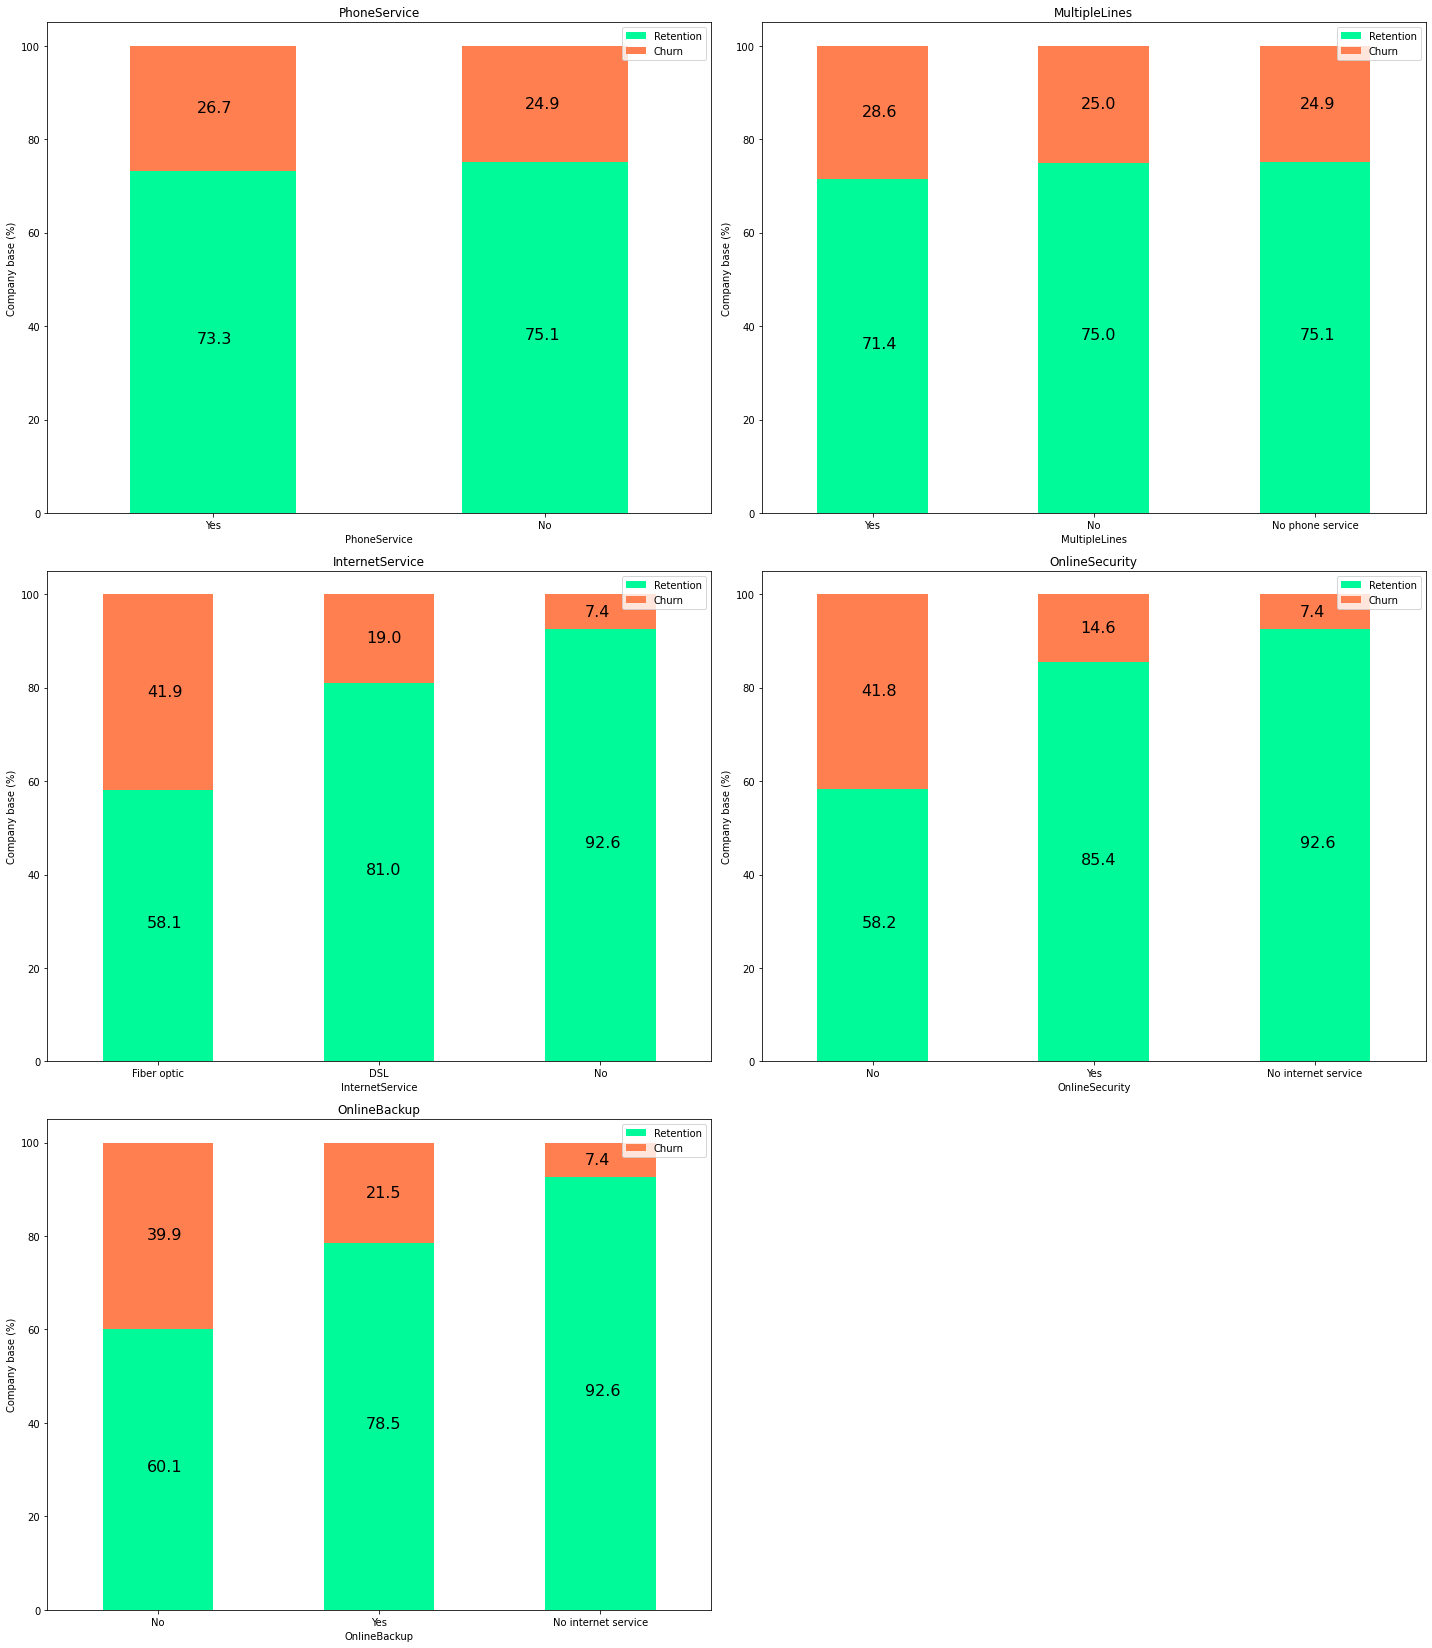

In [43]:
df_service = [phone_service_churn, lines_churn, internet_churn, security_churn, online_backup_churn]
titles = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup']
plot_stacked_bars(df_service, titles, size_=(20, 23))

- The number of customers who has no phone service is low.
- The churn rate between customers with phone service and without it displays similar churn rate.
- The churn rate between customers with multiple lines, customers without multiple lines, and customers with no phone service demonstrates a similar churn rate.
- Customers with internet service using fiber churn more.
- Customers with no online security churn more.
- Customers with no online backup churn more.

### DeviceProtection

In [44]:
device_protection = df[['customerID', 'DeviceProtection', 'Churn']]
device_protection = device_protection.groupby([device_protection['DeviceProtection'], device_protection['Churn']])['customerID'].count().unstack(level=1)
device_protection_churn = (device_protection.div(device_protection.sum(axis=1), axis=0) * 100).sort_values(by=['Yes'], ascending=False)

device_protection_churn

Churn,No,Yes
DeviceProtection,,
No,60.872375,39.127625
Yes,77.497936,22.502064
No internet service,92.595020,7.404980


### TechSupport

In [45]:
tech_support = df[['customerID', 'TechSupport', 'Churn']]
tech_support = tech_support.groupby([tech_support['TechSupport'], tech_support['Churn']])['customerID'].count().unstack(level=1)
tech_support_churn = (tech_support.div(tech_support.sum(axis=1), axis=0) * 100).sort_values(by=['Yes'], ascending=False)

tech_support_churn

Churn,No,Yes
TechSupport,,
No,58.364526,41.635474
Yes,84.833659,15.166341
No internet service,92.595020,7.404980


### StreamingTV

In [46]:
tv = df[['customerID', 'StreamingTV', 'Churn']]
tv = tv.groupby([tv['StreamingTV'], tv['Churn']])['customerID'].count().unstack(level=1)
tv_churn = (tv.div(tv.sum(axis=1), axis=0) * 100).sort_values(by=['Yes'], ascending=False)

tv_churn

Churn,No,Yes
StreamingTV,,
No,66.476868,33.523132
Yes,69.929812,30.070188
No internet service,92.595020,7.404980


### StreamingMovies

In [47]:
movies = df[['customerID', 'StreamingMovies', 'Churn']]
movies = movies.groupby([movies['StreamingMovies'], movies['Churn']])['customerID'].count().unstack(level=1)
movies_churn = (movies.div(movies.sum(axis=1), axis=0) * 100).sort_values(by=['Yes'], ascending=False)

movies_churn

Churn,No,Yes
StreamingMovies,,
No,66.319569,33.680431
Yes,70.058565,29.941435
No internet service,92.595020,7.404980


### Plot

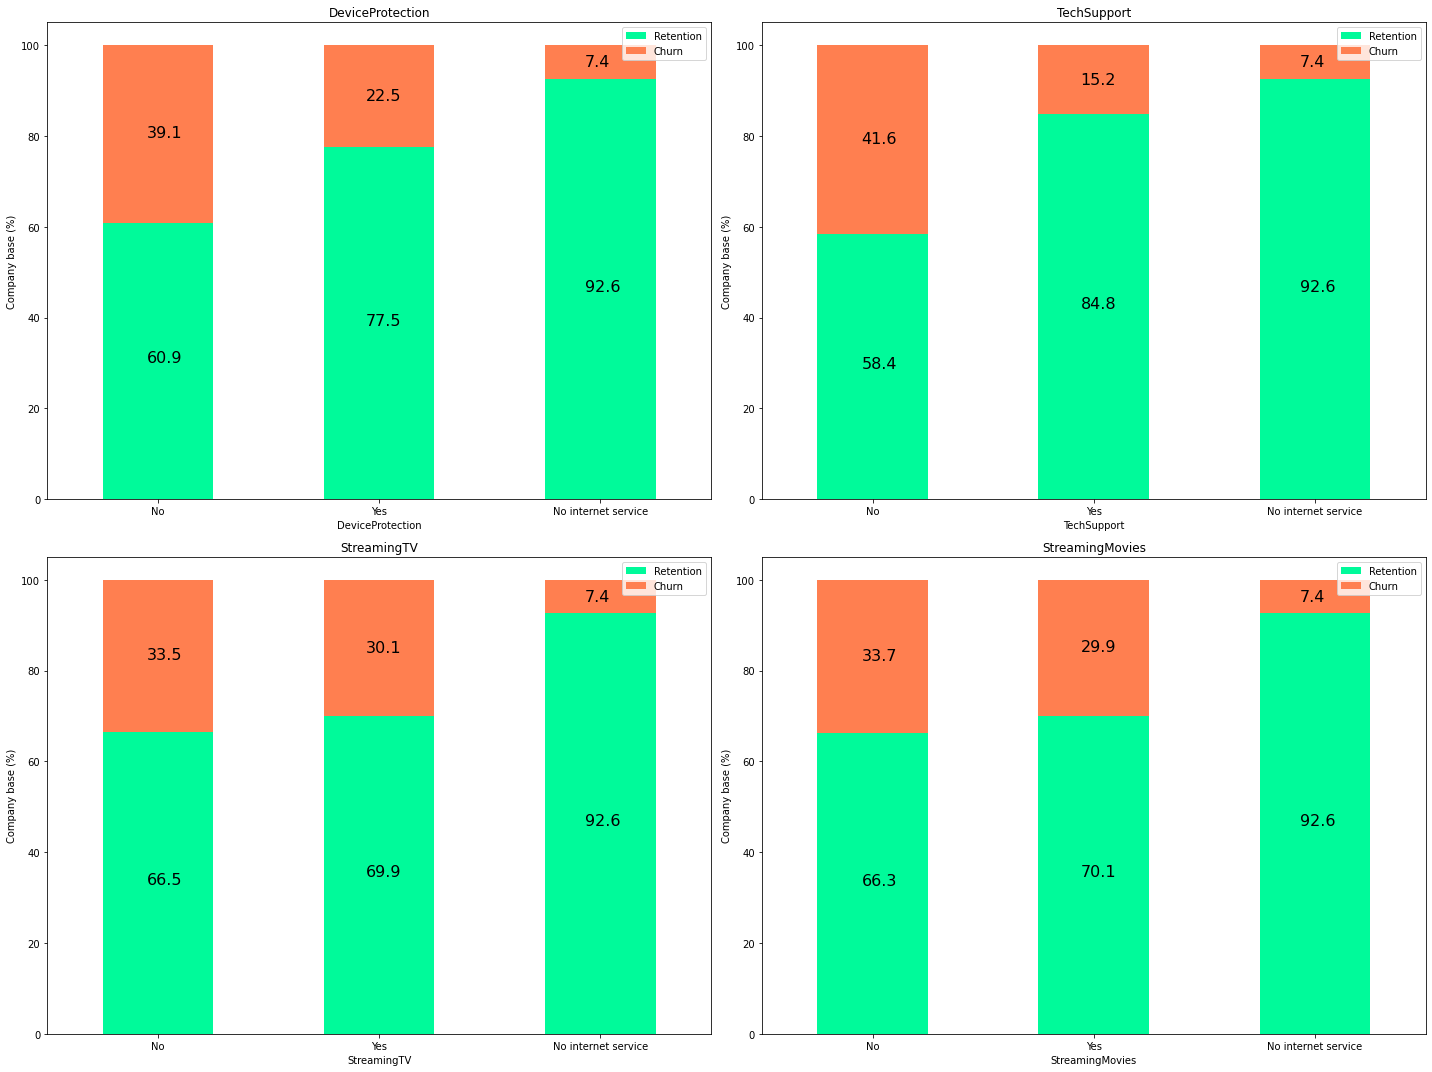

In [48]:
df_service = [device_protection_churn, tech_support_churn, tv_churn, movies_churn]
titles = ['DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
plot_stacked_bars(df_service, titles)

Customers without device prtection or without tech support churn more.

# Feature Engineering and Data Splitting

In [49]:
df = df.drop('customerID', axis = 1)

df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


In [50]:
df_transformed = df.copy()

## One-hot Encoding

In [51]:
categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

In [52]:
df_transformed = pd.get_dummies(df_transformed, columns = categorical_features)

In [53]:
le = LabelEncoder()

df_transformed['Churn'] = le.fit_transform(df_transformed['Churn'])
    
df_transformed

,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,29.85,29.85,0,1,0,1,0,0,1,...,0,1,0,0,0,1,0,0,1,0
1,34,56.95,1889.50,0,0,1,1,0,1,0,...,0,0,1,0,1,0,0,0,0,1
2,2,53.85,108.15,1,0,1,1,0,1,0,...,0,1,0,0,0,1,0,0,0,1
3,45,42.30,1840.75,0,0,1,1,0,1,0,...,0,0,1,0,1,0,1,0,0,0
4,2,70.70,151.65,1,1,0,1,0,1,0,...,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,24,84.80,1990.50,0,0,1,1,0,0,1,...,1,0,1,0,0,1,0,0,0,1
7039,72,103.20,7362.90,0,1,0,1,0,0,1,...,1,0,1,0,0,1,0,1,0,0
7040,11,29.60,346.45,0,1,0,1,0,0,1,...,0,1,0,0,0,1,0,0,1,0
7041,4,74.40,306.60,1,0,1,0,1,0,1,...,0,1,0,0,0,1,0,0,0,1


## Missing Value

In [54]:
df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 47 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   tenure                                   7043 non-null   int64  
 1   MonthlyCharges                           7043 non-null   float64
 2   TotalCharges                             7032 non-null   float64
 3   Churn                                    7043 non-null   int32  
 4   gender_Female                            7043 non-null   uint8  
 5   gender_Male                              7043 non-null   uint8  
 6   SeniorCitizen_0                          7043 non-null   uint8  
 7   SeniorCitizen_1                          7043 non-null   uint8  
 8   Partner_No                               7043 non-null   uint8  
 9   Partner_Yes                              7043 non-null   uint8  
 10  Dependents_No                            7043 no

In [55]:
df_transformed['TotalCharges'].fillna(df_transformed['TotalCharges'].mean(), inplace=True)

df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 47 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   tenure                                   7043 non-null   int64  
 1   MonthlyCharges                           7043 non-null   float64
 2   TotalCharges                             7043 non-null   float64
 3   Churn                                    7043 non-null   int32  
 4   gender_Female                            7043 non-null   uint8  
 5   gender_Male                              7043 non-null   uint8  
 6   SeniorCitizen_0                          7043 non-null   uint8  
 7   SeniorCitizen_1                          7043 non-null   uint8  
 8   Partner_No                               7043 non-null   uint8  
 9   Partner_Yes                              7043 non-null   uint8  
 10  Dependents_No                            7043 no

## Split Dataset

In [56]:
df_transformed_copy = df_transformed.copy()

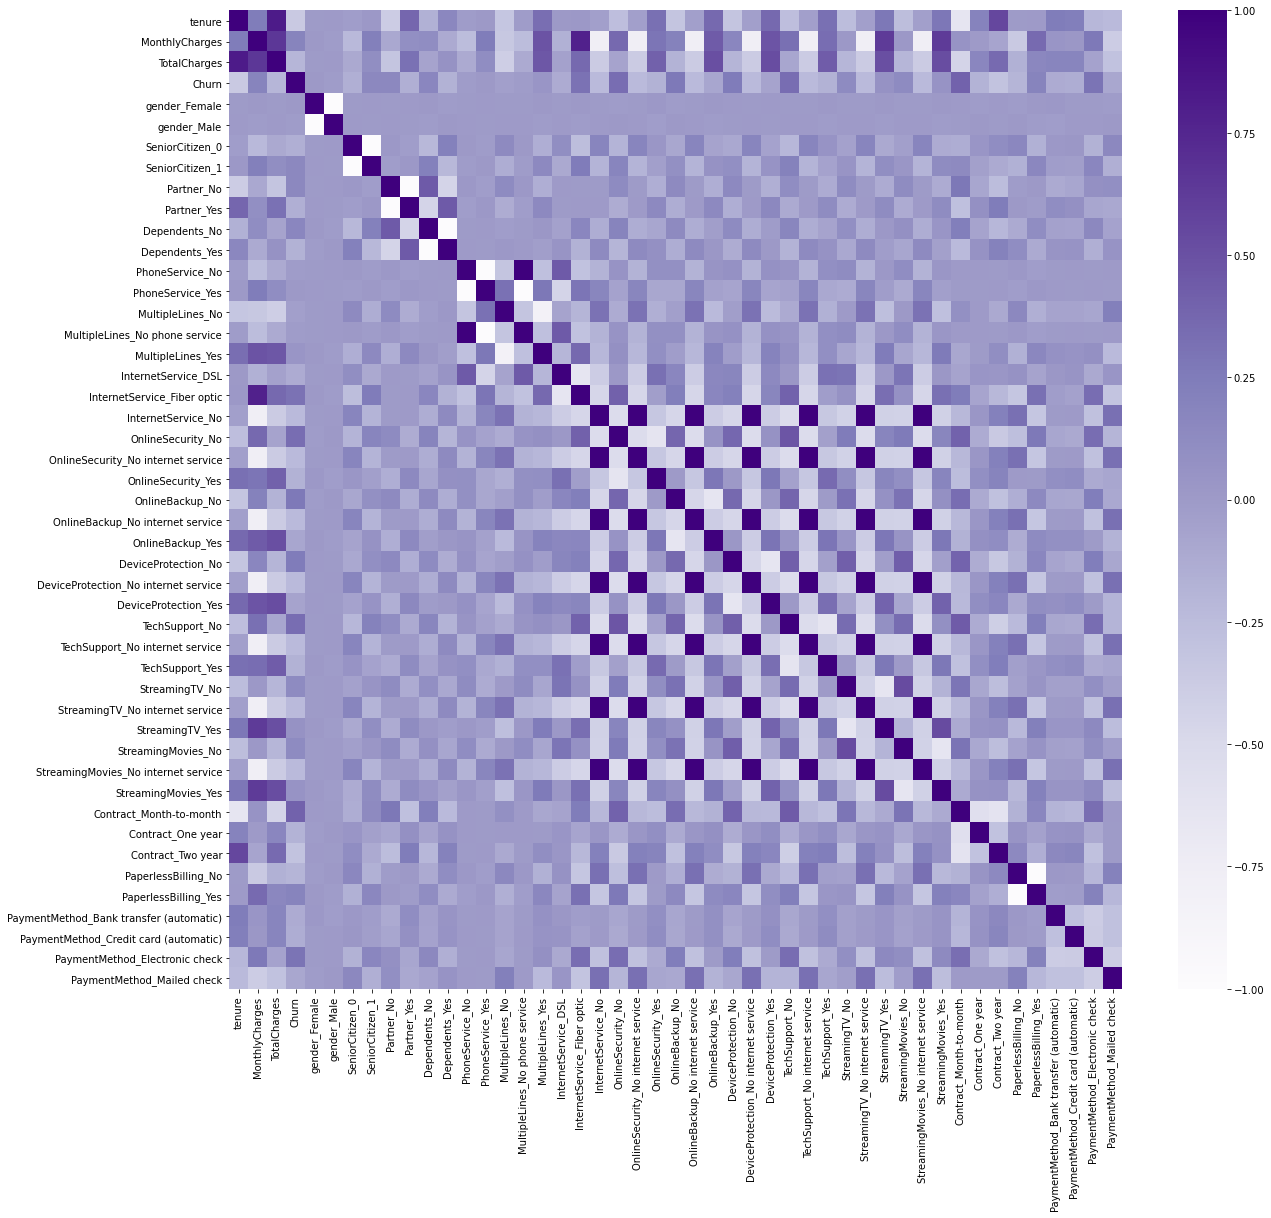

In [57]:
corr = df_transformed_copy.corr()
plt.figure(figsize=(20,18))
sns.heatmap(corr, cmap='Purples')
plt.show()

In [58]:
X = df_transformed_copy.drop(columns='Churn')
y = df_transformed_copy['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

In [59]:
np.array(X_train)

array([[3.50000e+01, 4.92000e+01, 1.70165e+03, ..., 0.00000e+00,
        1.00000e+00, 0.00000e+00],
       [1.50000e+01, 7.51000e+01, 1.15155e+03, ..., 0.00000e+00,
        0.00000e+00, 1.00000e+00],
       [1.30000e+01, 4.05500e+01, 5.90350e+02, ..., 0.00000e+00,
        0.00000e+00, 1.00000e+00],
       ...,
       [2.50000e+01, 1.02800e+02, 2.66020e+03, ..., 0.00000e+00,
        0.00000e+00, 1.00000e+00],
       [2.40000e+01, 2.04000e+01, 4.82800e+02, ..., 1.00000e+00,
        0.00000e+00, 0.00000e+00],
       [6.00000e+00, 2.06500e+01, 1.09300e+02, ..., 0.00000e+00,
        0.00000e+00, 1.00000e+00]])

## Data Scaling

In [60]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5634 entries, 3738 to 5639
Data columns (total 46 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   tenure                                   5634 non-null   int64  
 1   MonthlyCharges                           5634 non-null   float64
 2   TotalCharges                             5634 non-null   float64
 3   gender_Female                            5634 non-null   uint8  
 4   gender_Male                              5634 non-null   uint8  
 5   SeniorCitizen_0                          5634 non-null   uint8  
 6   SeniorCitizen_1                          5634 non-null   uint8  
 7   Partner_No                               5634 non-null   uint8  
 8   Partner_Yes                              5634 non-null   uint8  
 9   Dependents_No                            5634 non-null   uint8  
 10  Dependents_Yes                           5634

In [61]:
numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X_train.select_dtypes(include=['uint8']).columns

preprocessor = ColumnTransformer(transformers=[('numeric', MinMaxScaler(), numeric_features)],
                                 remainder='passthrough')

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [57]:
X_train

array([[0.48611111, 0.30692576, 0.19418529, ..., 0.        , 1.        ,
        0.        ],
       [0.20833333, 0.56502242, 0.13070696, ..., 0.        , 0.        ,
        1.        ],
       [0.18055556, 0.22072745, 0.06594776, ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.34722222, 0.8410563 , 0.30479636, ..., 0.        , 0.        ,
        1.        ],
       [0.33333333, 0.01993024, 0.05353712, ..., 1.        , 0.        ,
        0.        ],
       [0.08333333, 0.02242152, 0.0104374 , ..., 0.        , 0.        ,
        1.        ]])

# Modeling

In [62]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## Logistic Regression

In [63]:
pipeline_lr = imbpipeline(steps = [['smote', SMOTE(sampling_strategy = 1)],
                                ['classifier', LogisticRegression(random_state=42)]])

In [64]:
param_lr = {'classifier__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
random_search_lr = RandomizedSearchCV(estimator=pipeline_lr,
                           param_distributions=param_lr,
                           scoring='roc_auc',
                           cv=stratified_kfold,
                           n_jobs=-1)

In [65]:
random_search_lr.fit(X_train, y_train)

cv_score_lr = random_search_lr.best_score_

test_lr = random_search_lr.score(X_test, y_test)
print(f'Cross-validation score: {cv_score_lr}\nTest score: {test_lr}')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Cross-validation score: 0.8458311308057469
Test score: 0.839486941021468


In [66]:
y_pred_lr = random_search_lr.best_estimator_.predict(X_test)

In [67]:
roc_auc_score(y_test, y_pred_lr)

0.7519517424888269

In [68]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1035
           1       0.51      0.78      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409



## Random Forest

In [69]:
pipeline_rf = imbpipeline(steps = [['smote', SMOTE(sampling_strategy = 1)],
                                ['rf', RandomForestClassifier()]])

In [70]:
param_rf = {'rf__max_depth': [10, 20, 30],
            'rf__max_features': ['auto', 'sqrt'],
            'rf__min_samples_leaf': [1, 2, 4],
            'rf__min_samples_split': [2, 5, 10],
            'rf__n_estimators': [100, 500, 1000]}
random_search_rf = RandomizedSearchCV(estimator=pipeline_rf,
                           param_distributions=param_rf,
                           scoring='roc_auc',
                           cv=stratified_kfold,
                           n_jobs=-1)

In [73]:
random_search_rf.fit(X_train, y_train)

cv_score_rf = random_search_rf.best_score_

test_rf = random_search_rf.score(X_test, y_test)
print(f'Cross-validation score: {cv_score_rf}\nTest score: {test_rf}')

Cross-validation score: 0.8420046631946294
Test score: 0.8360691312097961


In [74]:
y_pred_rf = random_search_rf.predict(X_test)

In [75]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.88      0.79      0.83      1035
           1       0.54      0.70      0.61       374

    accuracy                           0.76      1409
   macro avg       0.71      0.74      0.72      1409
weighted avg       0.79      0.76      0.77      1409



In [76]:
roc_auc_score(y_test, y_pred_rf)

0.7439871864424294

## Xgboost

In [77]:
pipeline_xgbc = imbpipeline(steps = [['smote', SMOTE(sampling_strategy = 1)],
                                ['xgbc', XGBClassifier()]])

In [78]:
param_xgbc = {'xgbc__gamma': [0,0.1,0.2,0.4],
              'xgbc__learning_rate': [0.01, 0.1, 0.15],
              'xgbc__max_depth': [8, 10],
              'xgbc__n_estimators': [100, 500, 1000]}
random_search_xgbc = RandomizedSearchCV(estimator=pipeline_xgbc,
                           param_distributions=param_xgbc,
                           scoring='roc_auc',
                           cv=stratified_kfold,
                           n_jobs=-1)

In [79]:
random_search_xgbc.fit(X_train, y_train)

cv_score_xgbc = random_search_xgbc.best_score_

test_xgbc = random_search_xgbc.score(X_test, y_test)
print(f'Cross-validation score: {cv_score_xgbc}\nTest score: {test_xgbc}')

Cross-validation score: 0.8332033688205243
Test score: 0.8273024361259655


In [80]:
y_pred_xgbc = random_search_xgbc.predict(X_test)

In [81]:
roc_auc_score(y_test, y_pred_xgbc)

0.7275517321553128

In [82]:
print(classification_report(y_test, y_pred_xgbc))

              precision    recall  f1-score   support

           0       0.86      0.83      0.85      1035
           1       0.58      0.62      0.60       374

    accuracy                           0.78      1409
   macro avg       0.72      0.73      0.72      1409
weighted avg       0.78      0.78      0.78      1409

